<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ## install required packages
! git clone https://github.com/CodeArchitecture/FinRL.git
! pip install swig
! pip install wrds
! pip install -r requirements.txt 
# !pip install pyportfolioopt
# ## install finrl library
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

fatal: destination path 'FinRL' already exists and is not an empty directory.


^C


In [ ]:
import os
print(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

# import sys
# sys.path.append("../FinRL")

import itertools

d:\Anaconda\envs\fin\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [4]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [5]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [6]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
df.shape

(97013, 8)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.505281,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,42.888966,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.675968,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777538,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,41.156914,7325600,CAT,0


In [10]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [12]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.505281,493729600.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,6.505281,6.505281,20.040001,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,42.888966,5277400.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,42.888966,42.888966,20.040001,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,33.675968,6894300.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,33.675968,33.675968,20.040001,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777538,6186700.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,43.777538,43.777538,20.040001,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,41.156914,7325600.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,41.156914,41.156914,20.040001,0.0
5,2010-01-04,CRM,18.652500,18.882500,18.547501,18.705000,7906000.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,18.705000,18.705000,20.040001,0.0
6,2010-01-04,CSCO,24.110001,24.840000,24.010000,17.394127,59853700.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,17.394127,17.394127,20.040001,0.0
7,2010-01-04,CVX,78.199997,79.199997,78.160004,46.851887,10173800.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,46.851887,46.851887,20.040001,0.0
8,2010-01-04,DIS,32.500000,32.750000,31.870001,27.933920,13700400.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,27.933920,27.933920,20.040001,0.0
9,2010-01-04,GS,170.050003,174.250000,169.509995,139.862854,9135000.0,0.0,0.0,6.526812,6.494999,100.0,66.666667,100.0,139.862854,139.862854,20.040001,0.0


In [13]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [14]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [15]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,383.180176,3779900.0,3.0,-4.349257,419.212257,386.863790,40.895401,-222.938295,41.980385,405.947469,405.438423,23.139999,24.871851
2956,2021-09-30,V,227.580002,228.789993,222.630005,220.257767,7128500.0,3.0,-1.538727,228.639275,216.529591,44.078991,-54.614529,19.569853,224.777288,231.479428,23.139999,24.871851
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,49.822678,18736600.0,3.0,-0.237533,50.960817,49.550737,41.824969,-102.899226,21.682953,50.425972,50.960238,23.139999,24.871851
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,43.957287,6449400.0,3.0,-0.253540,48.531812,43.597244,44.613727,-107.390094,0.941150,45.886550,44.857786,23.139999,24.871851
2956,2021-09-30,WMT,140.639999,141.729996,139.250000,136.114761,7485900.0,3.0,-1.554836,146.155112,135.633128,40.165776,-151.542719,45.466733,142.345310,141.246726,23.139999,24.871851


In [16]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.404282,94639600.0,4.0,-1.703488,155.382854,137.132192,46.927745,-142.190084,41.749873,147.171803,146.269417,21.1,120.123454
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,203.845886,2629400.0,4.0,-3.097330,212.767988,199.379586,40.408547,-96.756921,36.189244,208.480832,217.103344,21.1,120.123454
0,2021-10-01,AXP,168.500000,175.119995,168.479996,170.695404,3956000.0,4.0,2.281750,174.864270,149.785740,56.265113,117.565579,15.667511,161.812906,164.064443,21.1,120.123454
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123454
0,2021-10-01,CAT,192.899994,195.869995,191.240005,187.928055,3695500.0,4.0,-3.640322,205.735916,181.432782,41.999456,-112.087699,36.203176,196.993866,200.522105,21.1,120.123454


In [17]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [18]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [19]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [20]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [21]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [22]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [23]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=100) if if_using_a2c else None

### Agent 2: DDPG

In [24]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [25]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=100) if if_using_ddpg else None

### Agent 3: PPO

In [26]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [27]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 42        |
|    iterations      | 1         |
|    time_elapsed    | 47        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.5885147 |
----------------------------------


### Agent 4: TD3

In [28]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [29]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=100) if if_using_td3 else None

### Agent 5: SAC

In [30]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [31]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100) if if_using_sac else None

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [32]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [33]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [34]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [35]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.139588
std        43.879123
min         0.000000
25%        14.613512
50%        23.644380
75%        38.292500
max       652.507065
Name: turbulence, dtype: float64

In [36]:
insample_risk_indicator.turbulence.quantile(0.996)

291.72558381131574

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [37]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='turbulence', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [38]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.404282,94639600.0,4.0,-1.703488,155.382854,137.132192,46.927745,-142.190084,41.749873,147.171803,146.269417,21.1,120.123454
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,203.845886,2629400.0,4.0,-3.097330,212.767988,199.379586,40.408547,-96.756921,36.189244,208.480832,217.103344,21.1,120.123454
0,2021-10-01,AXP,168.500000,175.119995,168.479996,170.695404,3956000.0,4.0,2.281750,174.864270,149.785740,56.265113,117.565579,15.667511,161.812906,164.064443,21.1,120.123454
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123454
0,2021-10-01,CAT,192.899994,195.869995,191.240005,187.928055,3695500.0,4.0,-3.640322,205.735916,181.432782,41.999456,-112.087699,36.203176,196.993866,200.522105,21.1,120.123454


In [39]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [40]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [41]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [42]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [43]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [44]:
df_account_value_a2c.shape

(353, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

In [45]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.505281
1,2010-01-04,AMGN,42.888966
2,2010-01-04,AXP,33.675968
3,2010-01-04,BA,43.777538
4,2010-01-04,CAT,41.156914


In [46]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [47]:
mvo.shape[0]

3310

### Helper functions

In [48]:
from scipy import optimize 
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
  #dependencies
  
    
  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
  return res

def MinimizeRisk(CovarReturns, PortfolioSize):
    
  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T) 
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b 
    return constraintVal
    
  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
  def  f(x,CovarReturns):
         
    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq 
    return EqconstraintVal
    
  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal
    

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
  return opt

In [49]:
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate mean returns and variance-covariance matrix

In [50]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()


array([[148.01605225, 198.85263062, 178.01608276, ...,  49.54628754,
         45.13446426, 145.26527405],
       [147.55015564, 196.85154724, 175.14341736, ...,  49.12624359,
         44.02268982, 144.07385254],
       [151.23765564, 197.41375732, 171.77886963, ...,  49.28492355,
         44.0039978 , 144.97227478],
       ...,
       [149.3999939 , 237.61999512, 175.13999939, ...,  38.52999878,
         36.20999908, 141.50999451],
       [146.71000671, 233.66000366, 174.25      , ...,  38.74000168,
         35.79999924, 141.88845825],
       [147.91999817, 234.44999695, 173.30000305, ...,  38.88000107,
         35.38999939, 140.86265564]])

In [51]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.073 0.078 0.069 0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.022 0.057 0.049 0.073 0.04  0.063 0.046 0.05  0.098 0.096 0.046 0.059
 0.109 0.095 0.042 0.035 0.051]
Variance-Covariance matrix of returns
 [[3.128 1.014 1.29  1.521 1.371 1.689 1.375 1.125 1.088 1.374 1.163 1.221
  1.03  1.525 0.692 1.269 0.664 0.816 1.029 0.733 1.576 1.139 0.668 0.86
  1.144 1.338 0.525 0.908 0.635]
 [1.014 2.4   1.072 1.01  1.066 1.211 1.025 0.965 0.937 1.122 0.978 1.029
  0.851 1.153 0.891 1.14  0.641 0.664 0.906 1.072 1.088 0.873 0.724 0.854
  1.146 1.056 0.631 1.025 0.645]
 [1.29  1.072 3.315 2.475 1.907 1.568 1.428 1.922 1.715 2.237 1.376 1.847
  1.343 1.508 0.861 2.37  0.99  1.075 1.375 0.964 1.357 1.418 0.728 1.505
  1.417 1.8   0.748 1.216 0.584]
 [1.521 1.01  2.475 4.962 2.117 1.687 1.511 2.143 1.838 2.201 1.527 2.121
  1.532 1.699 0.905 2.296 1.117 1.195 1.461 0.949 1.437 1.573 0.748 1.604
  1.472 1.716 0.734 1.362 0.603]
 [1.371 1.066 1.907

In [52]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([268510.,      0.,      0.,      0.,      0.,  67170.,      0.,
            0.,      0.,      0., 328490.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
        80330.,      0.,      0., 249920.,   5570.,      0.,      0.,
            0.])

In [53]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,147.341965,197.852112,179.354019,212.869995,196.628174,293.920013,53.038132,107.683975,172.009995,399.109955,...,77.8321,303.950806,161.721756,136.581009,156.46492,440.793518,231.263245,49.079575,45.98465,146.544556


In [54]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1822.359,    0.   ,    0.   ,    0.   ,    0.   ,  228.532,
          0.   ,    0.   ,    0.   ,    0.   ,  917.405,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,  496.717,    0.   ,    0.   ,
        566.977,   24.085,    0.   ,    0.   ,    0.   ])

In [55]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2021-10-26,1.002272e+06
2021-10-27,1.002461e+06
2021-10-28,1.011236e+06
2021-10-29,1.010909e+06
2021-11-01,1.001450e+06
...,...
2023-02-21,9.195315e+05
2023-02-22,9.194654e+05
2023-02-23,9.249119e+05
2023-02-24,9.120102e+05


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [56]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
result = pd.merge(result, MVO_result, left_index=True, right_index=True)
result = pd.merge(result, df_dji, left_index=True, right_index=True)
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (354, 8)
result:                       a2c          ddpg           td3           ppo  \
2021-10-26  1.015084e+06  1.048788e+06  1.032796e+06  1.001687e+06   
2021-10-27  1.011114e+06  1.041640e+06  1.029811e+06  1.001458e+06   
2021-10-28  1.010919e+06  1.041015e+06  1.029280e+06  1.001447e+06   
2021-10-29  1.010919e+06  1.041015e+06  1.029280e+06  1.001447e+06   
2021-11-01  1.011282e+06  1.040724e+06  1.029510e+06  1.001461e+06   
...                  ...           ...           ...           ...   
2023-02-21  9.499571e+05  8.939672e+05  8.329831e+05  9.855011e+05   
2023-02-22  9.457477e+05  8.905678e+05  8.301961e+05  9.853416e+05   
2023-02-23  9.472248e+05  8.944854e+05  8.347604e+05  9.855026e+05   
2023-02-24  9.371817e+05  8.868597e+05  8.251861e+05  9.847482e+05   
2023-02-27  9.408159e+05  8.894342e+05  8.276786e+05  9.850562e+05   

       

d:\Anaconda\envs\fin\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6292\143425230.py:23: FutureWarning: Passing 'suffixes' which cause duplicate columns {'account_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_6292\143425230.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'account_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = pd.merge(result, df_dji, left_index=True, right_index=True)


<AxesSubplot: >

<Figure size 1500x500 with 0 Axes>

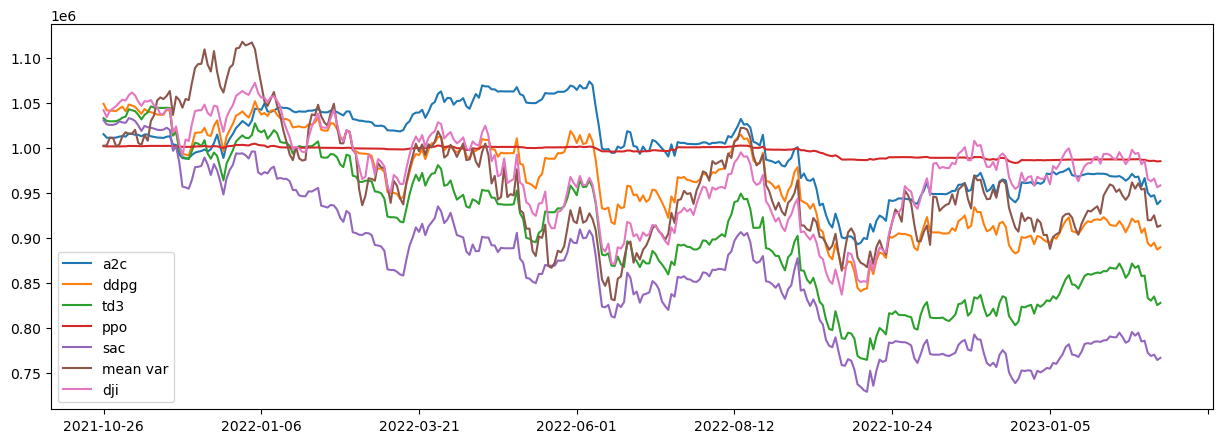

In [57]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()